In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-07-12 21:00:27.109164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import os

num_corrupted = 0
base_dir = '/Users/suprita/supriML/image_classification/bts_dataset'

for folder_name in ('RM', 'Jin', 'Suga', 'J-Hope', 'Jimin', 'Jungkook', 'V'):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, 'rb') as fobj:
                is_jfif = b'JFIF' in fobj.peek(10)
        except FileNotFoundError:
            print(f'File {fpath} not found.')
            continue
        except Exception as e:
            print(f'Error reading {fpath}: {e}')
            continue
            
        # image is corrupted
        if not is_jfif:
            num_corrupted += 1
            os.remove(fpath)

print(f'Total corrupted images deleted: {num_corrupted}')


Total corrupted images deleted: 75


In [2]:
# data augmentation and creating datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

image_size = (150, 150)
batch_size = 32 # efficient

# image cleaning and normalization
train_gen = ImageDataGenerator(
    rescale = 1./255, # normalize pixels
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2, # 80-20 split
    preprocessing_function=lambda img: cv2.resize(img, (150, 150)) # resize
)

test_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate datasets
train_ds = train_gen.flow_from_directory(
    'bts_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # set as training data
)

test_ds = test_gen.flow_from_directory(
    'bts_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # set as validation data
)

Found 223 images belonging to 7 classes.
Found 52 images belonging to 7 classes.


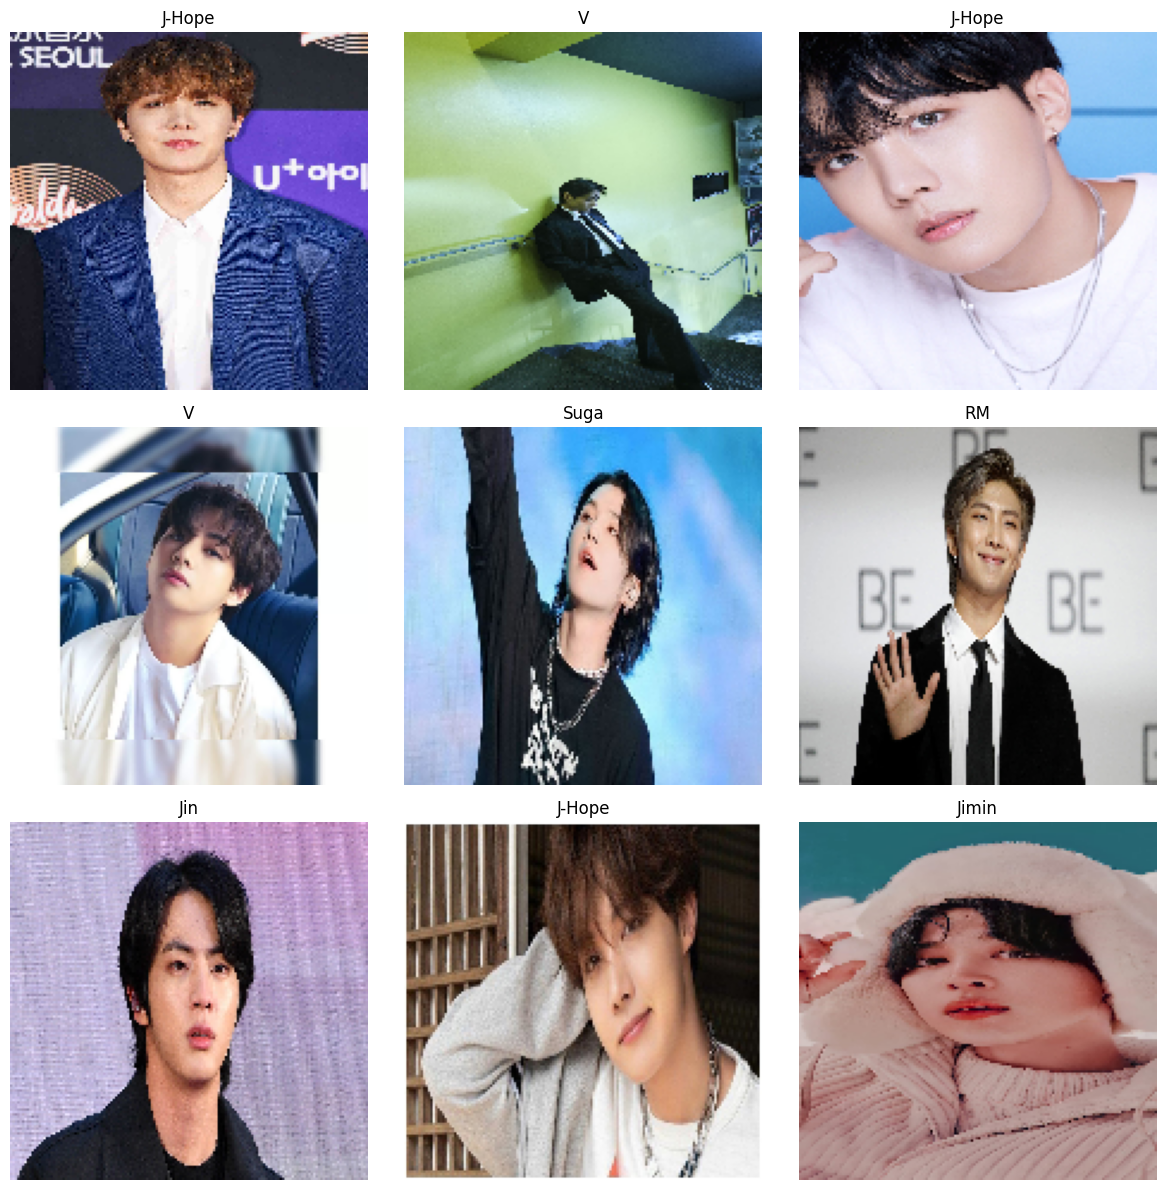

In [28]:
# visualize data

class_names = list(train_ds.class_indices.keys())

plt.figure(figsize=(12, 12))
for images, labels in train_ds:
    for i in range(min(len(images), 9)): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_idx = labels[i].argmax()
        plt.title(class_names[class_idx])  
        plt.axis("off")
    break  # break after first batch
plt.tight_layout()
plt.show()




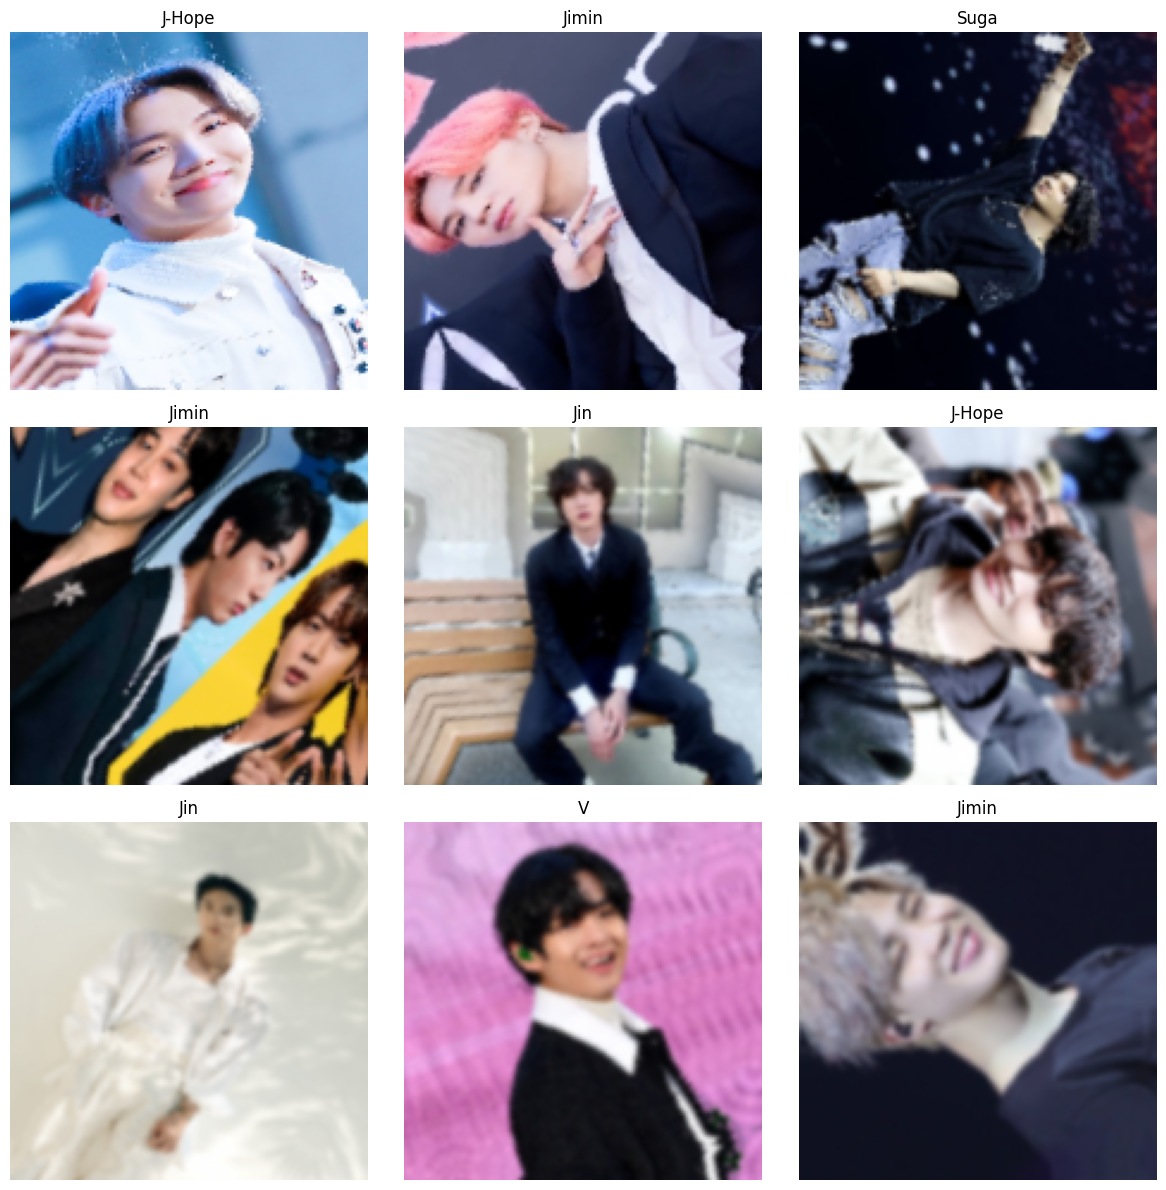

In [34]:
# data augmentation for better fitting
augment_layers = [
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
]

def augment(imgs):
    for layer in augment_layers:
        imgs = layer(imgs)
    return imgs

# visualize augmented data
plt.figure(figsize=(12, 12))
for images, labels in train_ds:
    for i in range(min(len(images), 9)): 
        images = augment(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_idx = labels[i].argmax()
        plt.title(class_names[class_idx])  
        plt.axis("off")
    break  
plt.tight_layout()
plt.show()



In [3]:
import tensorflow as tf

# convert to tensorflow datasets
train_ds = tf.data.Dataset.from_generator(
    lambda: train_ds,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 150, 150, 3], [None, 7])  # Adjust shapes as per your data
)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_ds,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 150, 150, 3], [None, 7])  # Adjust shapes as per your data
)


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [4]:
# Example code to print out the shape of the first batch from your train_ds
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape)  # This should print (batch_size, 150, 150, 3)


: 

In [17]:
# Define your CNN model function
def neuralnet(input_shape, num_classes):
    # Input layer + preprocessing
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0/255)(inputs)

    # Entry block
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    prev_activations = x  # Save activations for residual connections

    # Feature extraction blocks
    for size in [256, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual (skip layers as shortcuts)
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(prev_activations)
        x = layers.add([x, residual])
        prev_activations = x  # Update prev activations

    # Final block
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dropout for regularization
    x = layers.Dropout(0.25)(x)

    # Output layer, dense layer for final classification
    outputs = layers.Dense(num_classes, activation=None)(x)

    # Create the model
    model = keras.Model(inputs, outputs)
    return model

# Build the model
cnn = neuralnet(input_shape=(150, 150, 3), num_classes=7)

# Compile the model
cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name='acc')]
)

# Assuming train_ds and test_ds are correctly formatted tf.data.Dataset objects
# Train the model
epochs = 25
callbacks = [keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]

cnn.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds
)


Epoch 1/25


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, None, None, None, 150, 150, 3), dtype=float32). Expected shape (None, 150, 150, 3), but input has incompatible shape (None, None, None, None, None, 150, 150, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, None, None, None, None, 150, 150, 3), dtype=float32)
  • training=True
  • mask=None

In [15]:
# training
epochs = 25

# save weights
callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')
]
# compile model
cnn.compile(
    # adam = learning rate optimization algorithm
    optimizer=keras.optimizers.Adam(3e-4),
    # loss fn = binaryCrossentropy
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    # accuracy metrics = binaryAccuracy
    metrics=[keras.metrics.BinaryAccuracy(name='acc')]
)   
# train model
cnn.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds
)

Epoch 1/25


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, None, None, None, 150, 150, 3), dtype=float32). Expected shape (None, 150, 150, 3), but input has incompatible shape (None, None, None, None, None, 150, 150, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, None, None, None, None, 150, 150, 3), dtype=float32)
  • training=True
  • mask=None